In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/CI-HW3/

/content/drive/.shortcut-targets-by-id/1Eds0Rvfg3K1ciVROUnvCoM1--Tsq0w5N/CI-HW3


# Import Packages

In [64]:
import numpy as np
import pathlib
import tensorflow as tf
from keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory 
from keras.layers.experimental.preprocessing import Rescaling
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras.models import Model, load_model
from keras.applications.imagenet_utils import preprocess_input
from matplotlib.pyplot import imshow
%matplotlib inline
import keras.backend as K
K.set_image_data_format('channels_last')

# Data

## 1- Downloading the data

The Stanford Dogs dataset contains images of <strong>120</strong> breeds of dogs from around the world. This dataset has been built using images and annotation from <strong>ImageNet</strong> for the task of fine-grained image categorization.

- Number of images : 20,580
- Number of classes : 120

In [7]:
data_directory = '/root/.keras/datasets/Images'
dataset_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
data_directory = tf.keras.utils.get_file('Images', origin=dataset_url, untar = True)
data_directory = pathlib.Path(data_directory)

793583616/793579520 [==============================] - 21s 0us/step


## 2- Creating the dataset

- Since the pretraind weights which we want to use for transfer learning comes from **VGG16**, the images should be resized to **224x224**.

- The data is splited into two subsets: Train (90%) and Test(10%).

In [66]:
# Metadata
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
TEST_RATIO = 0.1
IMAGES_DIRECTORY = data_directory

# Training set
train_dataset = image_dataset_from_directory(IMAGES_DIRECTORY,
                                                    image_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]),
                                                    label_mode="categorical",
                                                    color_mode="rgb",
                                                    batch_size=BATCH_SIZE,
                                                    validation_split =  TEST_RATIO,
                                                    subset="training",                                                  
                                                    seed=222,
                                                    shuffle=True)
# Test set
test_dataset = image_dataset_from_directory(IMAGES_DIRECTORY,
                                                    image_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]),
                                                    label_mode="categorical",
                                                    color_mode="rgb",
                                                    batch_size=BATCH_SIZE,
                                                    validation_split =  TEST_RATIO,
                                                    subset="validation",
                                                    seed=222,
                                                    shuffle=True)

Found 20580 files belonging to 120 classes.
Using 18522 files for training.
Found 20580 files belonging to 120 classes.
Using 2058 files for validation.


## 3 - Data exploration



The images below are the first 9 images in the first batch. By re-running the cell below it shows the images from the next batch.

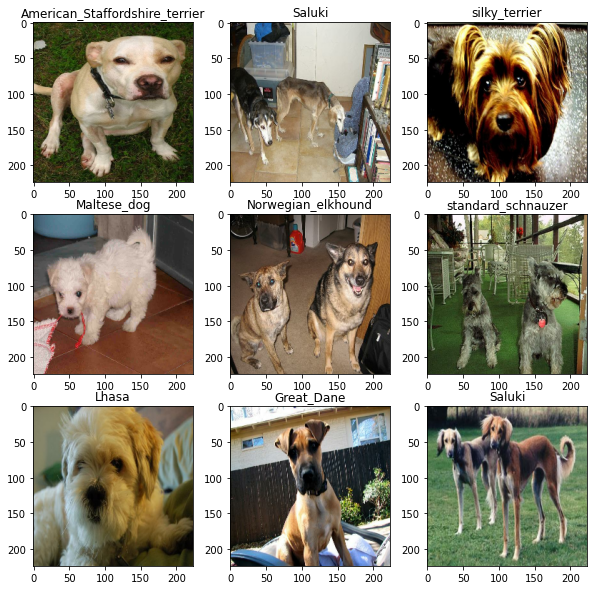

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):     
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        name_class = train_dataset.class_names[np.argmax(labels[i])]
        name_class = name_class.split('-')[1:]
        name_class = '-'.join(name_class)
        plt.title(name_class)
        plt.axis("on")

## 4 - Data augmentation

To avoid overfitting, we will augment our images in the training set by using this layer:

In [54]:
data_aug = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

# Models

The ImageNet Large Scale Visual Recognition Challenge (ILSVRC) is an annual computer vision competition. Each year, teams compete on two tasks. The first is to detect objects within an image coming from 200 classes, which is called object localization. The second is to classify images, each labeled with one of 1000 categories, which is called image classification. VGG 16 was proposed by Karen Simonyan and Andrew Zisserman of the Visual Geometry Group Lab of Oxford University in 2014 in the paper “**VERY DEEP CONVOLUTIONAL NETWORKS FOR LARGE-SCALE IMAGE RECOGNITION**”. This model won the **1st  and 2nd** place on the above categories in 2014 ILSVRC challenge.

## 1- Build the VGG_16 model

In [93]:
def VGG_16(input_shape = (224, 224, 3), classes = 120):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    
    # Normalizing the input
    X = Rescaling(1./255)(X_input)
  
    
    # Block 1
    X = Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding= 'same', activation = 'relu', name = 'block1_conv1')(X)
    X = Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding= 'same', activation = 'relu', name = 'block1_conv2')(X)
    X = MaxPooling2D((2, 2), strides=(2, 2), name = 'block1_pool')(X)


    # Block 2
    X = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding= 'same', activation = 'relu', name = 'block2_conv1')(X)
    X = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding= 'same', activation = 'relu', name = 'block2_conv2')(X)
    X = MaxPooling2D((2, 2), strides=(2, 2), name = 'block2_pool')(X)


    # Block 3
    X = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding= 'same', activation = 'relu', name = 'block3_conv1')(X)
    X = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding= 'same', activation = 'relu', name = 'block3_conv2')(X)
    X = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding= 'same', activation = 'relu', name = 'block3_conv3')(X)
    X = MaxPooling2D((2, 2), strides=(2, 2), name = 'block3_pool')(X)


    # Block 4
    X = Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding= 'same', activation = 'relu', name = 'block4_conv1')(X)
    X = Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding= 'same', activation = 'relu', name = 'block4_conv2')(X)
    X = Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding= 'same', activation = 'relu', name = 'block4_conv3')(X)
    X = MaxPooling2D((2, 2), strides=(2, 2), name = 'block4_pool')(X)
    

    # Block 5
    X = Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding= 'same', activation = 'relu', name = 'block5_conv1')(X)
    X = Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding= 'same', activation = 'relu', name = 'block5_conv2')(X)
    X = Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding= 'same', activation = 'relu', name = 'block5_conv3')(X)
    X = MaxPooling2D((2, 2), strides=(2, 2), name = 'block5_pool')(X)


    # Top Block
    X = Flatten()(X)
    X = Dense(4096, activation='relu', name='fc1')(X)
    X = Dense(4096, activation='relu', name='fc2')(X)
    X = Dense(256, activation='relu', name='fc')(X)
    X = Dropout(0.2)(X)
    X = Dense(classes, name='predictions')(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='vgg16')

    return model

In [94]:
base_model = VGG_16(input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3), classes = len(train_dataset.class_names))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling_15 (Rescaling)     (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584

In [95]:
# Freezing the base model's layers
base_model.trainable = False

# Adding a new dense layer at the top of the base model
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1, input_shape = (IMAGE_SIZE[0],IMAGE_SIZE[1], 3)),
  base_model,
  tf.keras.layers.Dense(len((train_dataset.class_names)), activation='softmax')
])

model.compile(optimizer= 'Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_16 (Rescaling)     (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 120)               135340216 
_________________________________________________________________
dense_10 (Dense)             (None, 120)               14520     
Total params: 135,354,736
Trainable params: 14,520
Non-trainable params: 135,340,216
_________________________________________________________________


With augmentation

In [84]:
# Freezing the base model's layers
base_model.trainable = False

# Adding a new dense layer at the top of the base model
model = tf.keras.Sequential([
  data_aug,
  layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1, input_shape = (IMAGE_SIZE[0],IMAGE_SIZE[1], 3)),
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len((train_dataset.class_names)), activation='softmax')
])

model.compile(optimizer= 'Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_14 (Rescaling)     (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 120)               61560     
Total params: 14,776,248
Trainable params: 61,560
Non-trainable params: 14,714,688
_________________________________________________________________


## 2 - Load VGG16 pretrained weights

The cell below, feed the model the weights of the VGG16 pretrained model on the ImageNet dataset with 1000 classes!


In [ ]:
TF_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'

weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                                        TF_WEIGHTS_PATH,
                                        cache_subdir='models')

model.load_weights(weights_path, by_name=True)

# Train

In [22]:
import datetime

save_at = "transfer_vgg16000.h5"
save_best= ModelCheckpoint(save_at,monitor='val_accuracy',verbose=0,save_best_only=True,save_weights_only=False,mode='max')

## 1 - First round (20 epochs)

Without augmentation.

In [ ]:
epochs=20

history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=test_dataset,
                    callbacks=[save_best],
                    verbose=1)
model.save_weights('weights/transfer_vgg16_weights.h5')

Epoch 1/20
290/290 [==============================] - 117s 404ms/step - loss: 4.4445 - accuracy: 0.0846 - val_loss: 4.1174 - val_accuracy: 0.1662
Epoch 2/20
290/290 [==============================] - 116s 401ms/step - loss: 3.8307 - accuracy: 0.2242 - val_loss: 3.6801 - val_accuracy: 0.2629
Epoch 3/20
290/290 [==============================] - 116s 400ms/step - loss: 3.4305 - accuracy: 0.3026 - val_loss: 3.3779 - val_accuracy: 0.3110
Epoch 4/20
290/290 [==============================] - 116s 399ms/step - loss: 3.1442 - accuracy: 0.3523 - val_loss: 3.1593 - val_accuracy: 0.3435
Epoch 5/20
290/290 [==============================] - 116s 400ms/step - loss: 2.9243 - accuracy: 0.3925 - val_loss: 2.9870 - val_accuracy: 0.3703
Epoch 6/20
290/290 [==============================] - 116s 400ms/step - loss: 2.7509 - accuracy: 0.4193 - val_loss: 2.8491 - val_accuracy: 0.3834
Epoch 7/20
290/290 [==============================] - 116s 400ms/step - loss: 2.6109 - accuracy: 0.4431 - val_loss: 2.7417 -

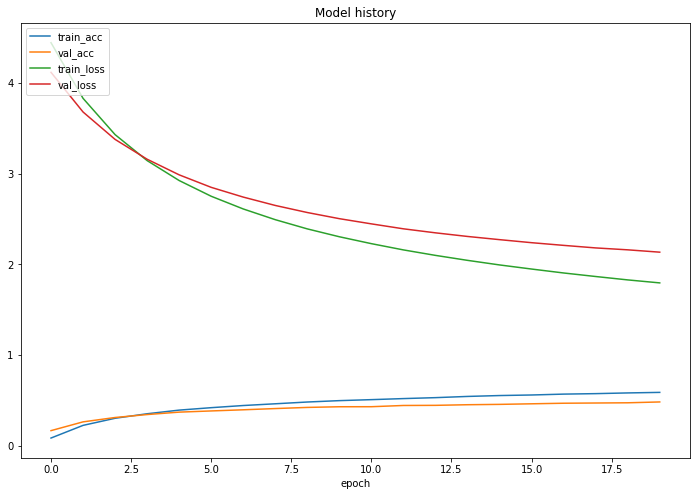

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model history')

plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc', 'train_loss', 'val_loss'], loc='upper left')

plt.show()

## 2 - Second round (30 epochs)

In [23]:
epochs=30

model.load_weights('weights/transfer_vgg16_weights.h5')

history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=test_dataset,
                    callbacks=[save_best],
                    verbose=1)
model.save_weights('weights/transfer_vgg16_weights.h5')

Epoch 1/30
290/290 [==============================] - 116s 401ms/step - loss: 1.7655 - accuracy: 0.5892 - val_loss: 2.1145 - val_accuracy: 0.4776
Epoch 2/30
290/290 [==============================] - 115s 395ms/step - loss: 1.7320 - accuracy: 0.6001 - val_loss: 2.0917 - val_accuracy: 0.4845
Epoch 3/30
290/290 [==============================] - 113s 391ms/step - loss: 1.7030 - accuracy: 0.6074 - val_loss: 2.0773 - val_accuracy: 0.4806
Epoch 4/30
290/290 [==============================] - 114s 393ms/step - loss: 1.6754 - accuracy: 0.6137 - val_loss: 2.0584 - val_accuracy: 0.4859
Epoch 5/30
290/290 [==============================] - 115s 395ms/step - loss: 1.6502 - accuracy: 0.6153 - val_loss: 2.0459 - val_accuracy: 0.4893
Epoch 6/30
290/290 [==============================] - 113s 391ms/step - loss: 1.6246 - accuracy: 0.6217 - val_loss: 2.0295 - val_accuracy: 0.4893
Epoch 7/30
290/290 [==============================] - 115s 395ms/step - loss: 1.6014 - accuracy: 0.6289 - val_loss: 2.0156 -

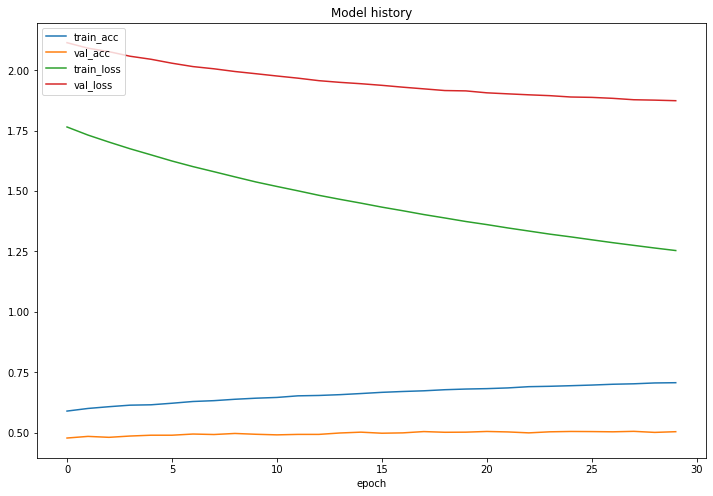

In [59]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model history')

plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc', 'train_loss', 'val_loss'], loc='upper left')

plt.show()

## 3 - Third round (20 epochs)

Adding augmentation to data but it did not make change at all!


In [67]:
epochs=20

model.load_weights('weights/transfer_vgg16_weights.h5')

history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=test_dataset,
                    callbacks=[save_best],
                    verbose=1)
model.save_weights('weights/transfer_new_vgg16_weights.h5')

Epoch 1/20
290/290 [==============================] - 119s 411ms/step - loss: 2.1368 - accuracy: 0.4656 - val_loss: 1.9114 - val_accuracy: 0.4932
Epoch 2/20
290/290 [==============================] - 120s 412ms/step - loss: 2.0942 - accuracy: 0.4732 - val_loss: 1.8759 - val_accuracy: 0.4990
Epoch 3/20
290/290 [==============================] - 121s 416ms/step - loss: 2.0727 - accuracy: 0.4842 - val_loss: 1.8447 - val_accuracy: 0.5112
Epoch 4/20
290/290 [==============================] - 120s 415ms/step - loss: 2.0380 - accuracy: 0.4891 - val_loss: 1.8278 - val_accuracy: 0.5194
Epoch 5/20
290/290 [==============================] - 120s 415ms/step - loss: 2.0232 - accuracy: 0.4948 - val_loss: 1.8090 - val_accuracy: 0.5233
Epoch 6/20
290/290 [==============================] - 121s 416ms/step - loss: 2.0030 - accuracy: 0.4983 - val_loss: 1.7929 - val_accuracy: 0.5282
Epoch 7/20
290/290 [==============================] - 120s 415ms/step - loss: 1.9820 - accuracy: 0.5045 - val_loss: 1.7789 -

# Test

In [68]:
# Compilde the model
model.compile(optimizer= 'Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Loads the weights
weights_dir = "weights/transfer_vgg16_weights.h5"
model.load_weights(weights_dir)

# Re-evaluate the model
loss, acc = model.evaluate(test_dataset, verbose=1)
print("accuracy: {:5.2f}%".format(100 * acc))

33/33 [==============================] - 10s 312ms/step - loss: 1.2776 - accuracy: 0.6958
accuracy: 69.58%


# Predict

Red labels indicated correct predictions

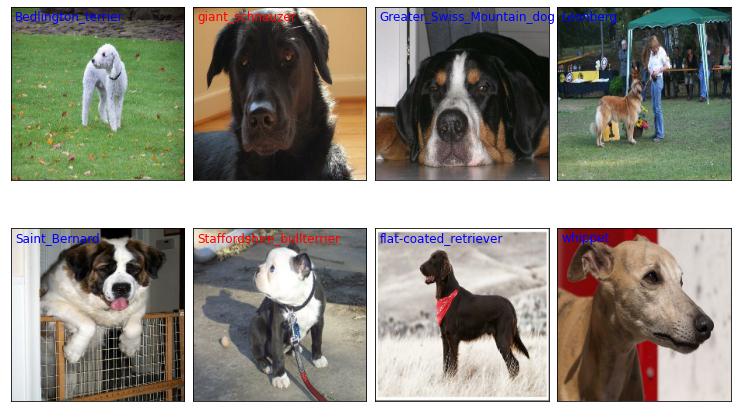

In [92]:
# Compilde the model
model.compile(optimizer= 'Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Loads the weights
weights_dir = "weights/transfer_vgg16_weights.h5"
model.load_weights(weights_dir)

# set up the figure
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 

for images, labels in test_dataset.take(1):
    prediction_values = model.predict(images)

# plot the images: each image is 224x224 pixels    
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(images[i].numpy().astype("uint8"))

    name_class = test_dataset.class_names[np.argmax(prediction_values[i])].split('-')[1:]
    name_class = '-'.join(name_class)

    if np.argmax(prediction_values[i]) == np.argmax(labels[i]):
        # label the image with the blue text
        ax.text(5, 17, name_class, color='blue', fontsize=12)
    else:
        # label the image with the red text
        ax.text(5, 17, name_class, color='red', fontsize=12)